In [8]:
import wandb
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
sns.set_theme()
# plt.style.use('seaborn-darkgrid')
plt.rcParams["axes.edgecolor"] = "0.25"
plt.rcParams["axes.linewidth"] = 1.2
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Lato"
legend_properties = {'weight':'normal'}
plt.rcParams['figure.constrained_layout.use'] = True
plt.rcParams["font.size"] = 12
plt.rcParams["font.weight"] = "bold"

In [36]:
RUNS_DICT = {
    "vanilla_rl_microwave": [
        "dashora7/online-franka/zqutn8ni",
        "dashora7/online-franka/p029j9hu",
        "dashora7/online-franka/mumd0imz",
        "dashora7/online-franka/8e76ycn5",
        "dashora7/online-franka/5dweb821",
        "dashora7/online-franka/3zxx4dqk"],
    "vanilla_rl_hingecabinet": None,
    "vanilla_rl_slidecabinet": None,
    "icvf_ataricnn_seohongds_rl_microwave":
        ["dashora7/online-franka/j2mvvomm",
         "dashora7/online-franka/ombfczol",
         "dashora7/online-franka/3k7bzbml",
         "dashora7/online-franka/0gg2wxvt",
         "dashora7/online-franka/mcqrlg6g",
         "dashora7/online-franka/j7ppo5z0"],
    "vf_ataricnn_customds_rl_minusrnd_microwave":
        ["dashora7/online-franka/wr93nqo0",
         "dashora7/online-franka/op1v8xr8",
         "dashora7/online-franka/0r408e6o",
         "dashora7/online-franka/g4giaoet",
         "dashora7/online-franka/njp5zdsq",
         "dashora7/online-franka/v608dnjx"],
}

In [51]:
api = wandb.Api()

def compute_mean_std_reward(run_name):
    seed_run_ids = RUNS_DICT[run_name]
    master_rews = []
    masters_steps = []
    for run_id in seed_run_ids:
        run = api.run(run_id)
        history = run.history(
            samples=500000,
            keys=["_step", "evaluation/return"],
            pandas=False)
        stepnums = []
        eval_rews = []
        for log_entry in history:
            eval_rew = log_entry["evaluation/return"]
            step = log_entry["_step"]
            stepnums.append(step)
            eval_rews.append(eval_rew)
            if step == 500000:
                break
        if stepnums[-1] < 500000:
            assert eval_rews[-1] >= 0, "Run did not reach 500K steps and was at 0 reward"
            continue_data(stepnums, eval_rews, 500000)
            print(f"Continued run {run_id} till 500K steps")
        # print("Run ID:", run_id, "Number of records:", len(stepnums), "Steps till", stepnums[-1])
        master_rews.append(eval_rews)
        masters_steps.append(stepnums)
        
    rew_array = np.stack(master_rews)
    assert all(len(master_rews[0]) == len(rewards) for rewards in master_rews), "Reward lengths do not match"
    assert all(masters_steps[0] == steplist for steplist in masters_steps), "Step numbers do not match"
    means = np.mean(rew_array, axis=0)
    stds = np.std(rew_array, axis=0)
    x = masters_steps[0]
    return x, means, stds

def smooth_data(step, data, window=10):
    smoothed_data = []
    for i in range(len(data)):
        start = max(0, i - window)
        end = min(len(data), i + window)
        smoothed_data.append(np.mean(data[start:end]))
    return smoothed_data


# Use if there's a success that had its job terminated and should be extended to 500K
# Note: it's not fair to extend 0 reward data, the method could still succeed
def continue_data(step, data, end_step):
    last_step = step[-1]
    delta = last_step - step[-2]
    last_data = data[-1]
    if last_step < end_step:
        step.extend(range(last_step, end_step + 1, delta)[1:])
        data.extend([last_data] * ((end_step - last_step + 1) // delta))

(-1.0, 80.0)

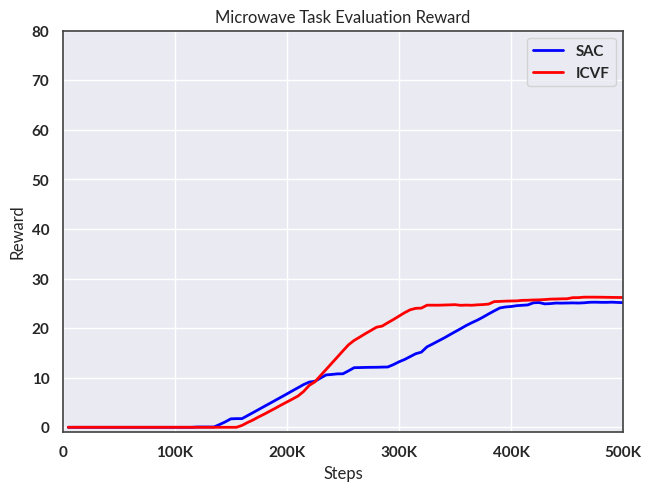

In [52]:
x, means, stds = compute_mean_std_reward("vanilla_rl_microwave")
means_smoothed = smooth_data(x, means)
plt.plot(x, means_smoothed, label="SAC", color="blue", linewidth=2)
x, means, stds = compute_mean_std_reward("icvf_ataricnn_seohongds_rl_microwave")
means_smoothed = smooth_data(x, means)
plt.plot(x, means_smoothed, label="ICVF", color="red", linewidth=2)
plt.title("Microwave Task Evaluation Reward")
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.xlim(0, 500000)
plt.xticks(ticks=[0, 100000, 200000, 300000, 400000, 500000], labels=["0", "100K", "200K", "300K", "400K", "500K"])
plt.ylim(-1, 80)

Continued run dashora7/online-franka/wr93nqo0 till 500K steps
Continued run dashora7/online-franka/op1v8xr8 till 500K steps
Continued run dashora7/online-franka/0r408e6o till 500K steps


(-1.0, 80.0)

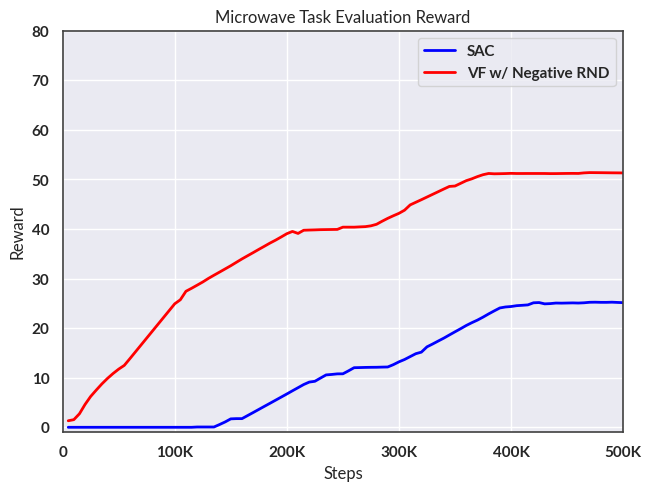

In [53]:
x, means, stds = compute_mean_std_reward("vanilla_rl_microwave")
means_smoothed = smooth_data(x, means)
plt.plot(x, means_smoothed, label="SAC", color="blue", linewidth=2)
x, means, stds = compute_mean_std_reward("vf_ataricnn_customds_rl_minusrnd_microwave")
means_smoothed = smooth_data(x, means)
plt.plot(x, means_smoothed, label="VF w/ Negative RND", color="red", linewidth=2)
plt.title("Microwave Task Evaluation Reward")
plt.legend()
plt.xlabel("Steps")
plt.ylabel("Reward")
plt.xlim(0, 500000)
plt.xticks(ticks=[0, 100000, 200000, 300000, 400000, 500000], labels=["0", "100K", "200K", "300K", "400K", "500K"])
plt.ylim(-1, 80)